# Project: Model Building Notebook

Michael Sorenson
Melody Song
Tarik Basic

### Import Packages

In [1]:
!sed -i 's/hadoop.root.logger=INFO,console/hadoop.root.logger=WARN,console/' /usr/hadoop-3.3.2/etc/hadoop/log4j.properties

import warnings
warnings.filterwarnings("ignore")

In [2]:
# initialize Spark

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import pyspark.sql.functions as F

import os
import dtreeviz

conf = pyspark.SparkConf().setAll([('spark.executor.memory', '8G'),
                                   ('spark.master', 'local[2]'),
                                   ('spark.app.name', 'PySpark DataFrame Demo')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print (spark.version, pyspark.version.__version__)

2023-06-02 23:51:47,038 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


3.3.1 3.3.1


### Load Data

In [3]:
# Update the filepath

#df = spark.read.csv('file:///home/work/project/mas-dse-230/Crimes_-_2001_to_Present.csv', header=True)
df = spark.read.csv('file:///home/work/project/Crimes_-_2001_to_Present.csv', header=True) 

1. data cleaning
2. features used
3. train/validation/test sets
4. analysis approach
    <br>a. input: cleaned, filtered training data
    <br>b. setup: create model, cross-validate for hyperparameters
    <br>c. output: final model, predictions, scores
5. challenges encountered
6. post-model analysis, discussion of results

### Data Cleanup & Feature Preparation

In [4]:
df.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location',
 'Historical Wards 2003-2015',
 'Zip Codes',
 'Community Areas',
 'Census Tracts',
 'Wards',
 'Boundaries - ZIP Codes',
 'Police Districts',
 'Police Beats']

In [5]:
from pyspark.sql.functions import regexp_replace

new_cats = {'CRIM SEXUAL ASSAULT':'CRIMINAL SEXUAL ASSAULT','NON-CRIMINAL (SUBJECT SPECIFIED)':'NON-CRIMINAL', 'NON - CRIMINAL':'NON-CRIMINAL',
            'OTHER NARCOTIC VIOLATION':'NARCOTICS','PUBLIC INDECENCY':'PUBLIC INDECENCY/OBSCENITY', 'OBSCENITY':'PUBLIC INDECENCY/OBSCENITY'}

for i in new_cats:
    df = df.replace(i,new_cats[i],"Primary Type")

In [6]:
## Drop NAs

df.select([count(when(col(c).isNotNull(), c)).alias(c) for c in df.columns]).toPandas()

2023-06-02 23:52:00,109 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,7781750,7781746,7781750,7781750,7781750,7781750,7781750,7771393,7781750,7781750,...,7695035,7695035,7672323,7695035,7675422,7677558,7675539,7675475,7676590,7676613


In [7]:
# Count number of NAs for each Year to see if there is any correlation between NA values and year
columns = pd.Series(df.columns)
columns = columns[columns != 'Year']
before_year_na = df.groupBy('Year').count().toPandas()
df2 = df.dropna()
after_year_na = df2.groupBy('Year').count().toPandas()
after_year_na.columns = ['Year', 'count_after']
final_na_counts = before_year_na.merge(after_year_na, on='Year')
final_na_counts['prop_kept'] = final_na_counts['count_after'] / final_na_counts['count']
final_na_counts = final_na_counts.sort_values(by='Year')
final_na_counts

,Year,count,count_after,prop_kept
19,2001,485878,3885,0.007996
8,2002,486802,343581,0.705792
21,2003,475979,469978,0.987392
12,2004,469421,465257,0.991129
7,2005,453771,448002,0.987287
11,2006,448174,443609,0.989814
16,2007,437084,433874,0.992656
15,2008,427167,418048,0.978652
10,2009,392819,384159,0.977954
20,2010,370496,368307,0.994092


In [8]:
df_final = df2.select('Date', 'Primary Type', 'Description', 'Location Description', 'Domestic', 'Beat', 'District',
                      'Ward', 'Zip Codes', 'Arrest')
df_final = df_final.where('Year > 2002 AND Year < 2023')
df_final.show()

+--------------------+---------------+--------------------+--------------------+--------+----+--------+----+---------+------+
|                Date|   Primary Type|         Description|Location Description|Domestic|Beat|District|Ward|Zip Codes|Arrest|
+--------------------+---------------+--------------------+--------------------+--------+----+--------+----+---------+------+
|09/05/2015 01:30:...|        BATTERY|DOMESTIC BATTERY ...|           RESIDENCE|    true|0924|     009|  12|    14924| false|
|09/04/2015 11:30:...|          THEFT|      POCKET-PICKING|             CTA BUS|   false|1511|     015|  29|     4299| false|
|09/05/2015 12:45:...|      NARCOTICS|POSS: HEROIN(BRN/...|            SIDEWALK|   false|1412|     014|  35|    21538|  true|
|09/05/2015 01:00:...|        ASSAULT|              SIMPLE|           APARTMENT|    true|1522|     015|  28|    22216| false|
|09/05/2015 10:55:...|       BURGLARY|      FORCIBLE ENTRY|           RESIDENCE|   false|0614|     006|  21|    21554|

In [9]:
df_length = df_final.count()
df_length

6634686

In [10]:
df_final.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Zip Codes: string (nullable = true)
 |-- Arrest: string (nullable = true)



### Feature Creation

<Axes: xlabel='Month'>

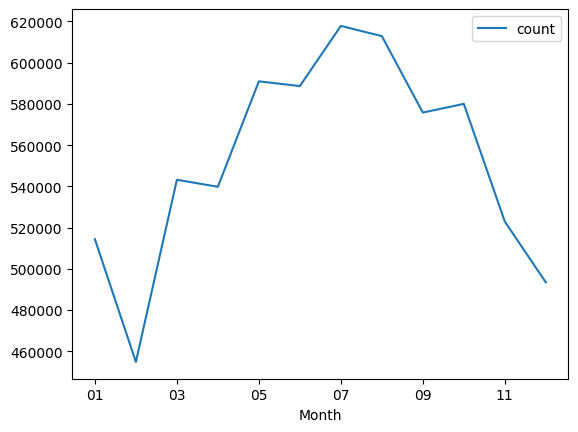

In [11]:
# Make Month column
df_final = df_final.withColumn('Month', substring('Date', 0, 2))
df_final.groupBy('Month').count().toPandas().sort_values('Month').plot(x='Month', y='count')

In [12]:
# Make Hour column
df_final = df_final.withColumn('Hour', from_unixtime(unix_timestamp('Date','MM/dd/yyyy hh:mm:ss a'),'HH'))

<Axes: xlabel='Month'>

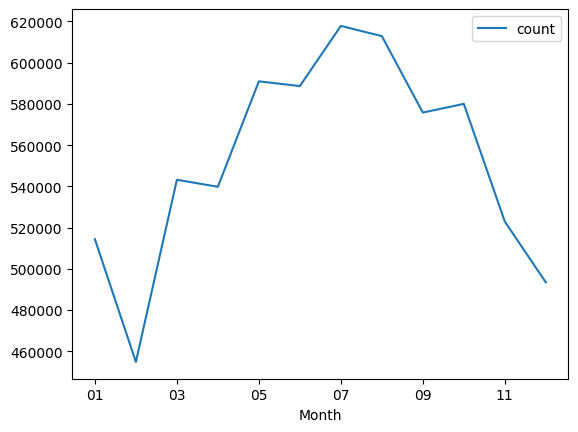

In [13]:
df_final = df_final.withColumn('Hour', substring('Date', 0, 2))
df_final.groupBy('Month').count().toPandas().sort_values('Month').plot(x='Month', y='count')

In [14]:
# Check the Location Description field
df_final.groupBy('Location Description').count().orderBy('count', ascending=False).show(10)

+--------------------+-------+
|Location Description|  count|
+--------------------+-------+
|              STREET|1694152|
|           RESIDENCE|1088377|
|           APARTMENT| 788074|
|            SIDEWALK| 656854|
|               OTHER| 223113|
|PARKING LOT/GARAG...| 169235|
|               ALLEY| 148224|
|  SMALL RETAIL STORE| 127645|
|SCHOOL, PUBLIC, B...| 124179|
|    RESIDENCE-GARAGE| 114583|
+--------------------+-------+
only showing top 10 rows



In [15]:
# Clean up Description field to reduce number of values in the field

print(df_final.select('Description').distinct().count())
mappings = {
    'AGGRAVATED':'AGG',
    'ATTEMPT':'ATT',
    'CRIMINAL':'CRIM',
    'POSSESSION':'POSS',
    'POS ':'POSS',
    'POSESS:':'POSS ',
    'POSESS ':'POSS ',    
    'REGISTRATION':'REG',
    'PRO. ':'PROFESSIONAL ',
    'PO ': 'POLICE OFFICER ',
    'P.O.':'POLICE OFFICER',
    'RITUAL': 'RIT',
    'MUTILATION':'MUT',
    'INSTRUMENT':'INSTR',
    'MANU/DEL:':'MANUFACTURE DELIVER',
    'MANU/DELIVER:':'MANUFACTURE DELIVER',
    'MANUFACTURE / DELIVER':'MANUFACTURE DELIVER'
}
replacement_expr = col('Description')
for k, v in mappings.items():
    replacement_expr = regexp_replace(replacement_expr, k, v)
df_final = df_final.withColumn('Description', replacement_expr)
df_final = df_final.withColumn('Description', regexp_replace(df_final['Description'], '[^A-Za-z0-9]', ''))
print(df_final.select('Description').distinct().count())

538


466


In [16]:
# Recast Arrest field into boolean
df_final = df_final.withColumn('Arrest', col('Arrest').cast('boolean').cast('int'))

### Train/Test Split Data
We will use train-validation split for hyperparameter tuning, but we need to pass a train_df into the the pipeline and test it on a holdout set.

In [17]:
# Create train/test dataset

df_train, df_test = df_final.randomSplit([0.80, 0.20], seed = 42)

In [18]:
# Check the size

print(df_train.count(),len(df_train.columns))
print(df_test.count(),len(df_test.columns))

5307677 12


1327009 12


### Build Logistic Regression model

In [19]:
# From https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.TrainValidationSplit.html
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplitModel
import tempfile

In [20]:
# Feature Preparation -- need to encode some categorical variables
cols = ['Primary Type', 'Description', 'Location Description', 'Ward', 'Month', 'Hour']

indexers = [
    StringIndexer(inputCol=c, handleInvalid='skip', outputCol='{0}_indexed'.format(c))
    for c in cols
]

encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol='{0}_encoded'.format(indexer.getOutputCol()))
    for indexer in indexers
]

assembler = VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders],
    outputCol='features'
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
model_lr = pipeline.fit(df_train)
df_train_enc = model_lr.transform(df_train).select('features', 'Arrest')

# Logistic Regressor
lr = LogisticRegression(labelCol='Arrest')
evaluator = BinaryClassificationEvaluator().setLabelCol('Arrest')

# Build parameter grid
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1, 2, 5])\
    .addGrid(lr.regParam, [1, 2])\
    .build()

# Train Validation Split - grid search
lr_tvs = TrainValidationSplit(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=2, seed=42)
lr_tvs_model = lr_tvs.fit(df_train_enc)

# Write model
model_path = 'file:///home/work/project/models/logreg'
lr_tvs_model.write().overwrite().save(model_path)


2023-06-03 00:13:09,957 WARN memory.MemoryStore: Not enough space to cache rdd_150_5 in memory! (computed 25.0 MiB so far)
2023-06-03 00:13:09,969 WARN storage.BlockManager: Persisting block rdd_150_5 to disk instead.
2023-06-03 00:14:36,767 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_150_4 in memory.
2023-06-03 00:14:36,769 WARN memory.MemoryStore: Not enough space to cache rdd_150_4 in memory! (computed 384.0 B so far)
2023-06-03 00:14:37,179 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_150_5 in memory.
2023-06-03 00:14:37,181 WARN memory.MemoryStore: Not enough space to cache rdd_150_5 in memory! (computed 384.0 B so far)
2023-06-03 00:14:37,608 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_150_6 in memory.
2023-06-03 00:14:37,611 WARN memory.MemoryStore: Not enough space to cache rdd_150_6 in memory! (

In [21]:
from itertools import chain

lrm = lr_tvs_model.bestModel

attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*df_train_enc
        .schema[lrm.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))

coef_list = pd.Series([(name, lrm.coefficients[idx]) for idx, name in attrs])
coef_list = pd.DataFrame({'Name': coef_list.apply(lambda x: x[0]), 'Coef': coef_list.apply(lambda x: x[1])})

In [22]:
print('maxIter:', lrm
    ._java_obj     # Get Java object
    .parent()      # Get parent (ALS estimator)
    .getMaxIter())
print('regParam:', lrm
    ._java_obj
    .parent()
    .getRegParam())
print('intercept:', lrm.intercept)
coef_list['Name'] = coef_list['Name'].str.replace('_indexed_encoded_', ': ')
coef_sorted = coef_list.sort_values(by='Coef', ascending=False)

maxIter: 5
regParam: 1.0
intercept: -1.082302255555415


In [23]:
pd.set_option('max_colwidth', 1000)
coef_sorted[:20]

,Name,Coef
477,Description: AGGPOOTHERDANGEROUSWEAPON,0.642371
445,Description: UNLAWFULUSEOFBODYARMOR,0.621045
465,Description: ARSONISTDUTYTOREGISTER,0.619262
169,Description: GUNOFFENDERANNUALREG,0.618824
447,Description: ARSONISTFAILTOREGISTERNEWADDRESS,0.618170
126,Description: PAROLEVIOLATION,0.615899
198,Description: GUNOFFENDERDUTYTOREGISTER,0.610852
294,Description: BOARDPLANEWITHWEAPON,0.602953
255,Description: GUNOFFENDERDUTYTOREPORTCHANGEOFINFORMATION,0.601409
680,Location Description: PUBLIC HIGH SCHOOL,0.579249


In [24]:
coef_sorted[-20:]

,Name,Coef
479,Description: AGGRITMUTKNIFECUTTINGI,-0.211606
482,Description: ATTAGGOTHERFIREARM,-0.214488
408,Description: AGGOFANUNBORNCHILD,-0.218683
464,Description: AGGRITMUTHANDSFISTFEETSERIOUSINJURY,-0.218751
489,Description: SECONDDEGREEMURDER,-0.220060
469,Description: SALEOFTOBACCOPOLICEOFFICERUCTSTOMINOR,-0.220295
488,Description: POLICEOFFICERECTEDEMPOLICEOFFICEREEHANDSNOMININJURY,-0.236273
478,Description: AGGRITMUTHANDSFISTSFEETSERIOUSINJURY,-0.236288
691,Location Description: LAGOON,-0.252593
694,Location Description: POLICE FACILITY,-0.256430


### Evaluate Logistic Regression

#### ROC AUC Train

In [25]:
evaluator.evaluate(lr_tvs_model.transform(df_train_enc))

0.8929753422176305

#### ROC AUC Test

In [26]:
df_test_enc = pipeline.fit(df_train).transform(df_test).select('features', 'Arrest')
evaluator.evaluate(lr_tvs_model.transform(df_test_enc))

0.893185931070912

#### Training Accuracy

In [27]:
train_preds = lr_tvs_model.transform(df_train_enc)
train_preds = train_preds.withColumn("prediction", train_preds.prediction.cast('int'))
train_preds = train_preds.withColumn("isCorrect", col('Arrest') == col('prediction'))
train_preds = train_preds.withColumn('isCorrect', col('isCorrect').cast('integer'))
train_preds.select(mean('isCorrect')).show()

+------------------+
|    avg(isCorrect)|
+------------------+
|0.7995661755604194|
+------------------+



**Training Accuracy**: 79.96%

#### Test Accuracy

In [28]:
test_preds = lr_tvs_model.transform(df_test_enc)
test_preds = test_preds.withColumn("prediction", test_preds.prediction.cast('int'))
test_preds = test_preds.withColumn("isCorrect", col('Arrest') == col('prediction'))
test_preds = test_preds.withColumn('isCorrect', col('isCorrect').cast('integer'))
test_preds.select(mean('isCorrect')).show()

+------------------+
|    avg(isCorrect)|
+------------------+
|0.7989055036047394|
+------------------+



**Test Accuracy**: 79.92%

##### Confusion Matrix

In [29]:
# Confusion Matrix

true_negs = test_preds.filter((test_preds.Arrest == 0) & (test_preds.prediction == 0)).count()
print('True Negatives: ',true_negs)
true_pos = test_preds.filter((test_preds.Arrest == 1) & (test_preds.prediction == 1)).count()
print('True Positives: ',true_pos)
false_neg = test_preds.filter((test_preds.Arrest == 1) & (test_preds.prediction == 0)).count()
print('False Negatives: ',false_neg)
false_pos = test_preds.filter((test_preds.Arrest == 0) & (test_preds.prediction == 1)).count()
print('False Positives: ',false_pos)

True Negatives:  981492


True Positives:  78658


False Negatives:  266408


False Positives:  445


### Feature Prep: Vectorize features (non encoded) for Decision Tree / Random Forest models

In [30]:
# Assemble features into single vector column for RF and DT

cols = ['Primary Type', 'Description', 'Location Description', 'Month', 'Hour']

#df_final.withColumn('target')
indexers = [
    StringIndexer(inputCol=c, handleInvalid='keep', outputCol='{0}_indexed'.format(c))
    for c in cols
]

assembler = VectorAssembler(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCol='features'
)

pipeline2 = Pipeline(stages=indexers + [assembler])
df_train_vec = pipeline2.fit(df_train).transform(df_train).select('features', 'Arrest')
df_test_vec = pipeline2.fit(df_train).transform(df_test).select('features', 'Arrest')

### Build Decision Tree model

In [31]:
# Decision Tree

dt = DecisionTreeClassifier(featuresCol='features',labelCol='Arrest',maxBins=475)
evaluator = BinaryClassificationEvaluator().setLabelCol('Arrest')
grid = ParamGridBuilder().addGrid(dt.maxDepth, [3, 5, 10]).build()\

dt_tvs = TrainValidationSplit(estimator=dt, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=1, seed=42)
dt_tvs_model = dt_tvs.fit(df_train_vec)

print(dt_tvs_model.getTrainRatio())
model_path = 'file:///home/work/project/models/dectree'
dt_tvs_model.write().overwrite().save(model_path)

train_error = evaluator.evaluate(dt_tvs_model.transform(df_train_vec))

2023-06-03 01:21:24,834 WARN memory.MemoryStore: Not enough space to cache rdd_1064_9 in memory! (computed 18.4 MiB so far)
2023-06-03 01:21:25,802 WARN memory.MemoryStore: Not enough space to cache rdd_1064_9 in memory! (computed 7.7 MiB so far)
2023-06-03 01:24:12,341 WARN memory.MemoryStore: Not enough space to cache rdd_1128_9 in memory! (computed 18.4 MiB so far)
2023-06-03 01:24:13,341 WARN memory.MemoryStore: Not enough space to cache rdd_1128_9 in memory! (computed 7.7 MiB so far)
2023-06-03 01:24:14,257 WARN memory.MemoryStore: Not enough space to cache rdd_1128_9 in memory! (computed 7.7 MiB so far)
2023-06-03 01:24:15,101 WARN memory.MemoryStore: Not enough space to cache rdd_1128_9 in memory! (computed 7.7 MiB so far)
2023-06-03 01:24:27,647 WARN memory.MemoryStore: Not enough space to cache rdd_1193_9 in memory! (computed 18.4 MiB so far)
2023-06-03 01:24:28,618 WARN memory.MemoryStore: Not enough space to cache rdd_1193_9 in memory! (computed 7.7 MiB so far)
2023-06-03 01

0.75


#### Evaluate Decision Tree

##### Train ROC AUC

In [32]:
# Train ROC AUC
evaluator.evaluate(dt_tvs_model.transform(df_train_vec))

0.6359757164800905

##### Test ROC AUC

In [35]:
# Test ROC AUC
df_test_enc = pipeline2.fit(df_train).transform(df_test).select('features', 'Arrest')
evaluator.evaluate(dt_tvs_model.transform(df_test_vec))

2023-06-03 01:55:08,557 WARN netty.NettyRpcEnv: Ignored failure: java.util.concurrent.TimeoutException: Cannot receive any reply from 1fc37cfb29cc:36101 in 10000 milliseconds
2023-06-03 01:55:11,027 WARN executor.Executor: Issue communicating with driver in heartbeater
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [10000 milliseconds]. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:103)
	at org.apache.spark.executor.Executor

0.6366296703256312

##### Training Accuracy

In [36]:
# Training Accuracy
train_preds = dt_tvs_model.transform(df_train_vec)
train_preds = train_preds.withColumn("prediction", train_preds.prediction.cast('int'))
train_preds = train_preds.withColumn("isCorrect", col('Arrest') == col('prediction'))
train_preds = train_preds.withColumn('isCorrect', col('isCorrect').cast('integer'))
train_preds.select(mean('isCorrect')).show()

+------------------+
|    avg(isCorrect)|
+------------------+
|0.8859764827437691|
+------------------+



##### Test Accuracy

In [37]:
# Test Accuracy
test_preds = dt_tvs_model.transform(df_test_vec)
test_preds = test_preds.withColumn("prediction", test_preds.prediction.cast('int'))
test_preds = test_preds.withColumn("isCorrect", col('Arrest') == col('prediction'))
test_preds = test_preds.withColumn('isCorrect', col('isCorrect').cast('integer'))
test_preds.select(mean('isCorrect')).show()

+------------------+
|    avg(isCorrect)|
+------------------+
|0.8858915048805246|
+------------------+



##### Confusion Matrix

In [38]:
# Confusion Matrix

true_negs = test_preds.filter((test_preds.Arrest == 0) & (test_preds.prediction == 0)).count()
print('True Negatives: ',true_negs)
true_pos = test_preds.filter((test_preds.Arrest == 1) & (test_preds.prediction == 1)).count()
print('True Positives: ',true_pos)
false_neg = test_preds.filter((test_preds.Arrest == 1) & (test_preds.prediction == 0)).count()
print('False Negatives: ',false_neg)
false_pos = test_preds.filter((test_preds.Arrest == 0) & (test_preds.prediction == 1)).count()
print('False Positives: ',false_pos)

True Negatives:  959259


True Positives:  216327


False Negatives:  128742


False Positives:  22681


#### Build Random Forest model

In [39]:
# Random Forest

rf = RandomForestClassifier(labelCol='Arrest',maxBins=475)
evaluator = BinaryClassificationEvaluator().setLabelCol('Arrest')
grid = ParamGridBuilder()\
       .addGrid(rf.maxDepth, [3, 5, 10])\
       .addGrid(rf.numTrees, [3, 5, 7, 10, 15])\
       .build()

rf_tvs = TrainValidationSplit(estimator=rf, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=1, seed=42)
rf_tvs_model = rf_tvs.fit(df_train_vec)

print(rf_tvs_model.getTrainRatio())
model_path = 'file:///home/work/project/models/randfor'
rf_tvs_model.write().overwrite().save(model_path)

rf_train_error = evaluator.evaluate(rf_tvs_model.transform(df_train_vec))

2023-06-03 03:21:53,068 WARN memory.MemoryStore: Not enough space to cache rdd_1498_9 in memory! (computed 8.3 MiB so far)
2023-06-03 03:21:53,109 WARN memory.MemoryStore: Not enough space to cache rdd_1498_8 in memory! (computed 12.7 MiB so far)
2023-06-03 03:21:53,663 WARN memory.MemoryStore: Not enough space to cache rdd_1498_10 in memory! (computed 19.7 MiB so far)
2023-06-03 03:21:55,031 WARN memory.MemoryStore: Not enough space to cache rdd_1498_9 in memory! (computed 8.3 MiB so far)
2023-06-03 03:21:55,057 WARN memory.MemoryStore: Not enough space to cache rdd_1498_8 in memory! (computed 12.7 MiB so far)
2023-06-03 03:21:55,694 WARN memory.MemoryStore: Not enough space to cache rdd_1498_10 in memory! (computed 19.7 MiB so far)
2023-06-03 03:24:14,031 WARN memory.MemoryStore: Not enough space to cache rdd_1579_0 in memory! (computed 41.6 MiB so far)
2023-06-03 03:24:14,037 WARN memory.MemoryStore: Not enough space to cache rdd_1579_1 in memory! (computed 41.6 MiB so far)
2023-06-

0.75


2023-06-03 03:52:13,181 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1411.2 KiB


##### Train ROC AUC

In [40]:
# Train ROC AUC
evaluator.evaluate(rf_tvs_model.transform(df_train_vec))

2023-06-03 03:54:44,779 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1411.2 KiB


0.8940977061136788

##### Test ROC AUC

In [41]:
# Test ROC AUC
evaluator.evaluate(rf_tvs_model.transform(df_test_vec))

2023-06-03 03:57:50,689 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1411.2 KiB


0.8944923780833869

##### Training Accuracy

In [42]:
# Training Accuracy
train_preds = rf_tvs_model.transform(df_train_vec)
train_preds = train_preds.withColumn("prediction", train_preds.prediction.cast('int'))
train_preds = train_preds.withColumn("isCorrect", col('Arrest') == col('prediction'))
train_preds = train_preds.withColumn('isCorrect', col('isCorrect').cast('integer'))
train_preds.select(mean('isCorrect')).show()

2023-06-03 04:00:19,072 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1422.0 KiB


+------------------+
|    avg(isCorrect)|
+------------------+
|0.8857242066538714|
+------------------+



##### Test Accuracy

In [43]:
# Test Accuracy
test_preds = rf_tvs_model.transform(df_test_vec)
test_preds = test_preds.withColumn("prediction", test_preds.prediction.cast('int'))
test_preds = test_preds.withColumn("isCorrect", col('Arrest') == col('prediction'))
test_preds = test_preds.withColumn('isCorrect', col('isCorrect').cast('integer'))
test_preds.select(mean('isCorrect')).show()

2023-06-03 04:02:40,746 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1422.1 KiB


+------------------+
|    avg(isCorrect)|
+------------------+
|0.8857897723376406|
+------------------+



##### Confusion Matrix

In [44]:
# Confusion Matrix

true_negs = test_preds.filter((test_preds.Arrest == 0) & (test_preds.prediction == 0)).count()
print('True Negatives: ',true_negs)
true_pos = test_preds.filter((test_preds.Arrest == 1) & (test_preds.prediction == 1)).count()
print('True Positives: ',true_pos)
false_neg = test_preds.filter((test_preds.Arrest == 1) & (test_preds.prediction == 0)).count()
print('False Negatives: ',false_neg)
false_pos = test_preds.filter((test_preds.Arrest == 0) & (test_preds.prediction == 1)).count()
print('False Positives: ',false_pos)

2023-06-03 04:04:43,265 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1421.7 KiB


True Negatives:  962510


2023-06-03 04:06:44,953 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1421.7 KiB


True Positives:  212941


2023-06-03 04:08:43,711 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1421.7 KiB


False Negatives:  132128


2023-06-03 04:10:40,544 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1421.7 KiB


False Positives:  19430
